In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import preliz as pz
import xarray as xr
from scipy.interpolate import PchipInterpolator
from scipy.stats import linregress

In [2]:
plt.rc("figure", dpi=150)
np.random.seed(123)

<Axes: xlabel='temperature', ylabel='rented'>

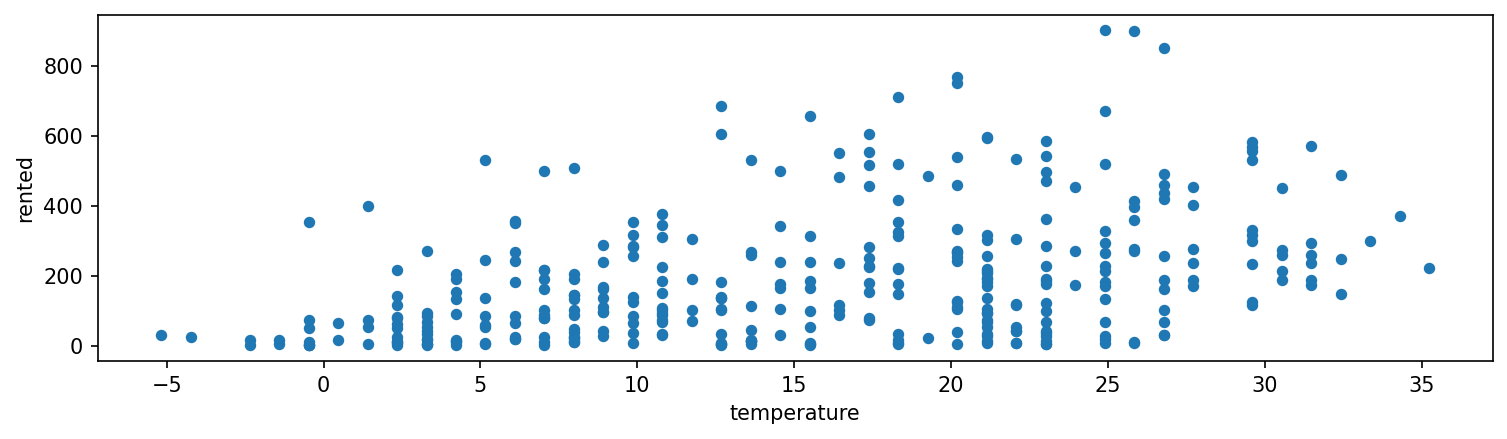

In [4]:
bikes = pd.read_csv("https://github.com/aloctavodia/BAP3/raw/refs/heads/main/code/data/bikes.csv")
bikes.plot(x="temperature", y="rented", figsize=(12, 3), kind="scatter")

In [10]:
coords = {"data": np.arange(len(bikes))}
with pm.Model(coords=coords) as model_lb:
    β0 = pm.Normal("β0", mu=0, sigma=100)
    β1 = pm.Normal("β1", mu=0, sigma=10)
    σ = pm.HalfNormal("σ", 10)
    μ = pm.Deterministic("μ", β0 + β1 * bikes.temperature, dims="data")
    y_pred = pm.Normal("y_pred", mu=μ, sigma=σ, observed=bikes.rented, dims="data")
    

In [11]:
idata_lb = pm.sample(random_seed=123, model=model_lb)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [β0, β1, σ]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 32 seconds.


In [12]:
idata_lb

Inference data with groups:
	> posterior
	> sample_stats
	> observed_data

array([<Axes: title={'center': 'β0'}>, <Axes: title={'center': 'β1'}>,
       <Axes: title={'center': 'σ'}>], dtype=object)

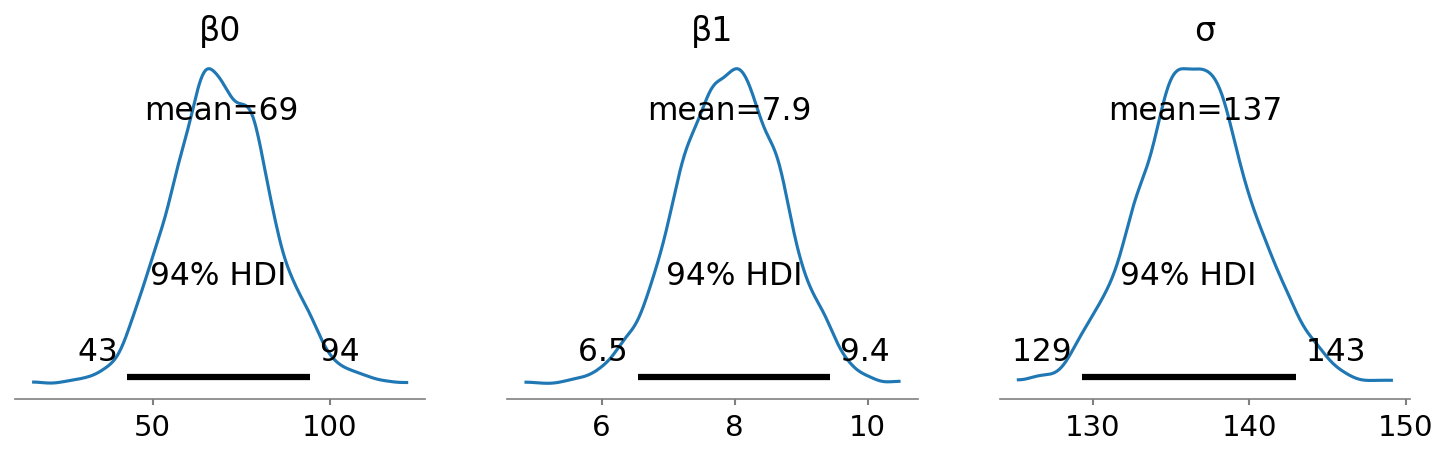

In [13]:
az.plot_posterior(idata_lb, var_names=["~μ"], figsize=(12, 3))

<Axes: xlabel='β0', ylabel='β1'>

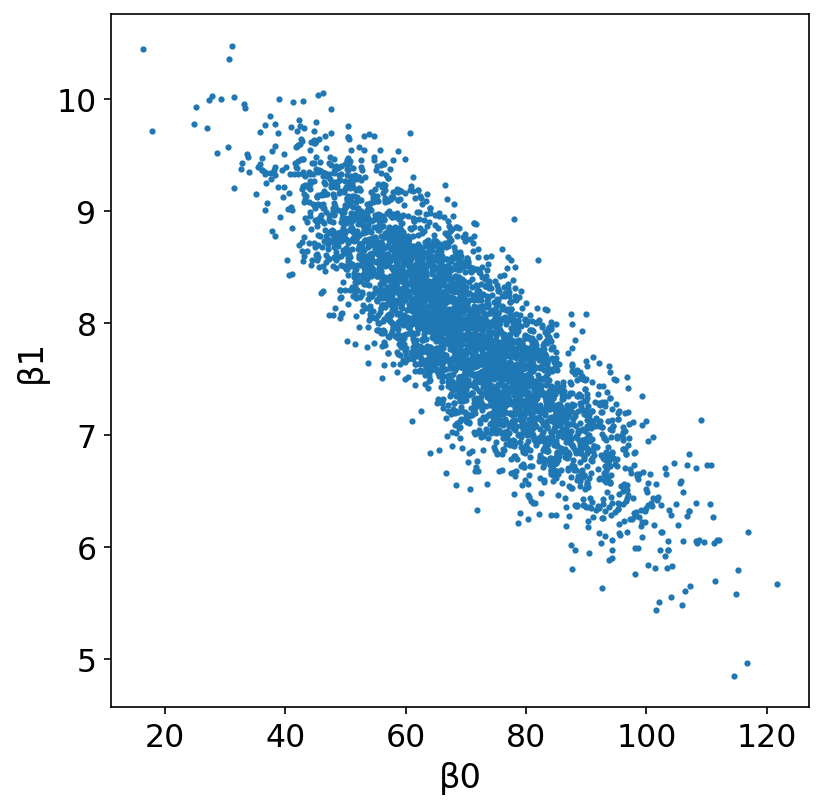

In [26]:
az.plot_pair(idata_lb, var_names=["β0", "β1"], kind="scatter", figsize=(6, 6))

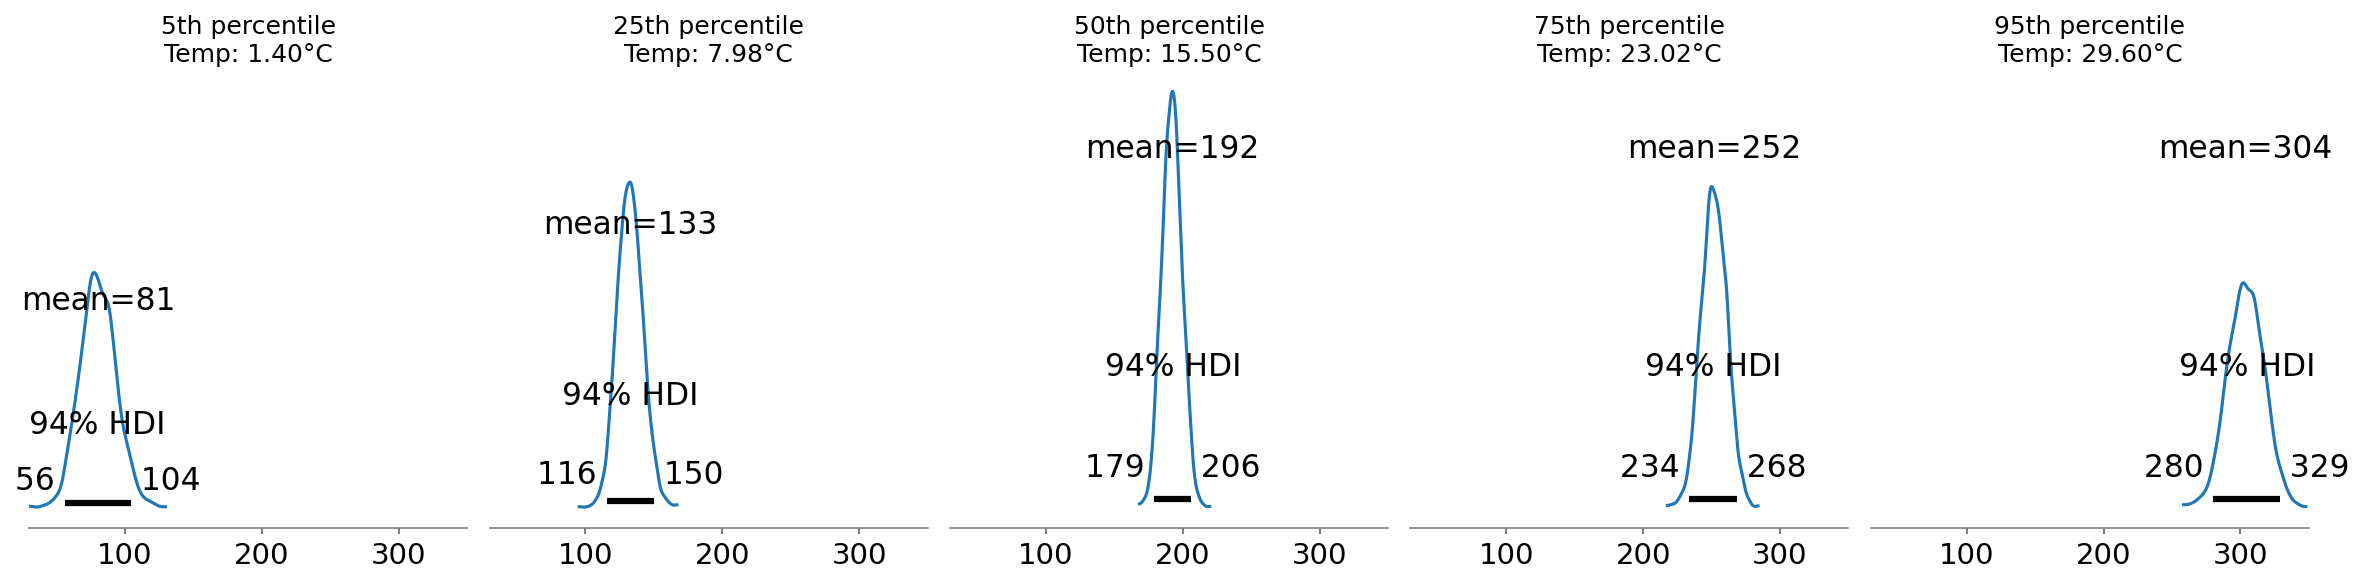

In [32]:
# Define percentiles to calculate
percentiles = [5, 25, 50, 75, 95]

# Initialize list to store indexes
percentile_idxs = []

# Create figure with subplots
fig, axes = plt.subplots(1, len(percentiles), figsize=(16, 4), sharey=True)

# Calculate percentile indices
for i,p in enumerate(percentiles):
    # Calculate the percentile value
    p_value = np.percentile(bikes.temperature, p)
    
    # Find index where temperature is closest to this value
    idx = np.abs(bikes.temperature - p_value).argmin()
    
    # Store this index
    percentile_idxs.append(idx)
    mu_posterior = idata_lb.posterior["μ"].sel(data=idx)

    temp_value = bikes.temperature.iloc[idx]

    # Plot the posterior distribution
    az.plot_posterior(mu_posterior, ax=axes[i], point_estimate="mean")
    axes[i].set_title(f"{p}th percentile\nTemp: {temp_value:.2f}°C")
    axes[i].set_xlim(30, 350)

plt.tight_layout()


In [ ]:
az.plot_posterior(idata_lb, var_names=["μ"], coords={"data": percentile_idxs}, point_estimate="mean", combined=True, figsize=(8, 4))

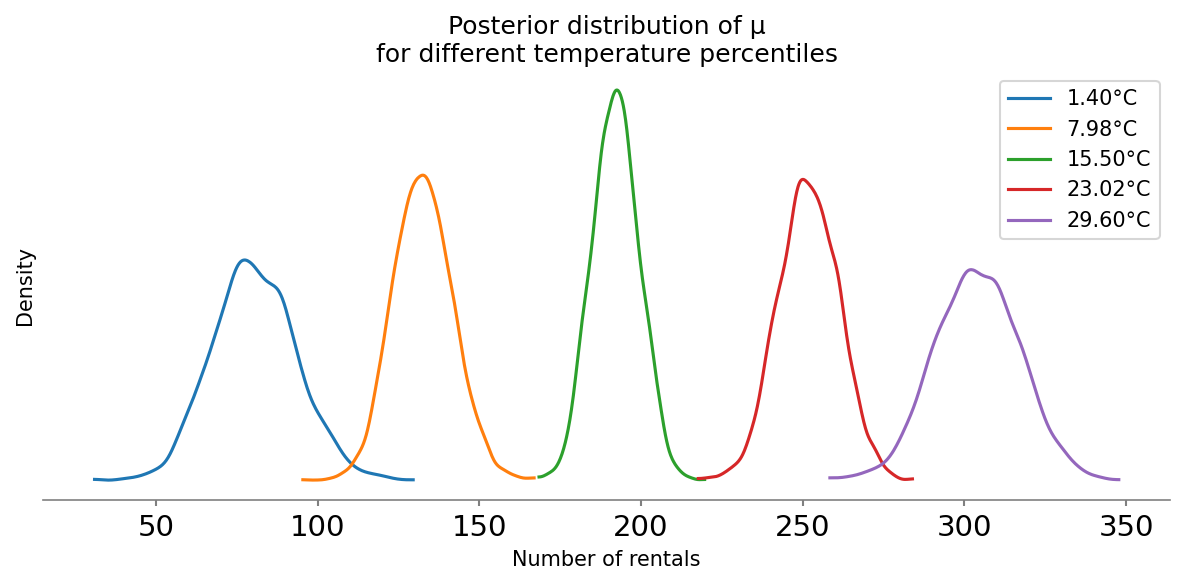

In [45]:
# Define percentiles to calculate
percentiles = [5, 25, 50, 75, 95]

# Initialize list to store indexes
percentile_idxs = []

# Create figure with subplots
fig, axes = plt.subplots(1, 1, figsize=(8, 4), sharey=True)

# Calculate percentile indices
for i,p in enumerate(percentiles):
    # Calculate the percentile value
    p_value = np.percentile(bikes.temperature, p)
    
    # Find index where temperature is closest to this value
    idx = np.abs(bikes.temperature - p_value).argmin()
    
    # Store this index
    percentile_idxs.append(idx)
    mu_posterior = idata_lb.posterior["μ"].sel(data=idx)

    temp_value = bikes.temperature.iloc[idx]

    # Plot the posterior distribution
    az.plot_posterior(mu_posterior, ax=axes, point_estimate=None, 
        hdi_prob="hide", label=f"{temp_value:.2f}°C",
        color=f"C{i}")

    axes.set_xlabel('Number of rentals')
    axes.set_ylabel('Density')
    axes.set_title(f"Posterior distribution of μ\nfor different temperature percentiles")


plt.tight_layout()


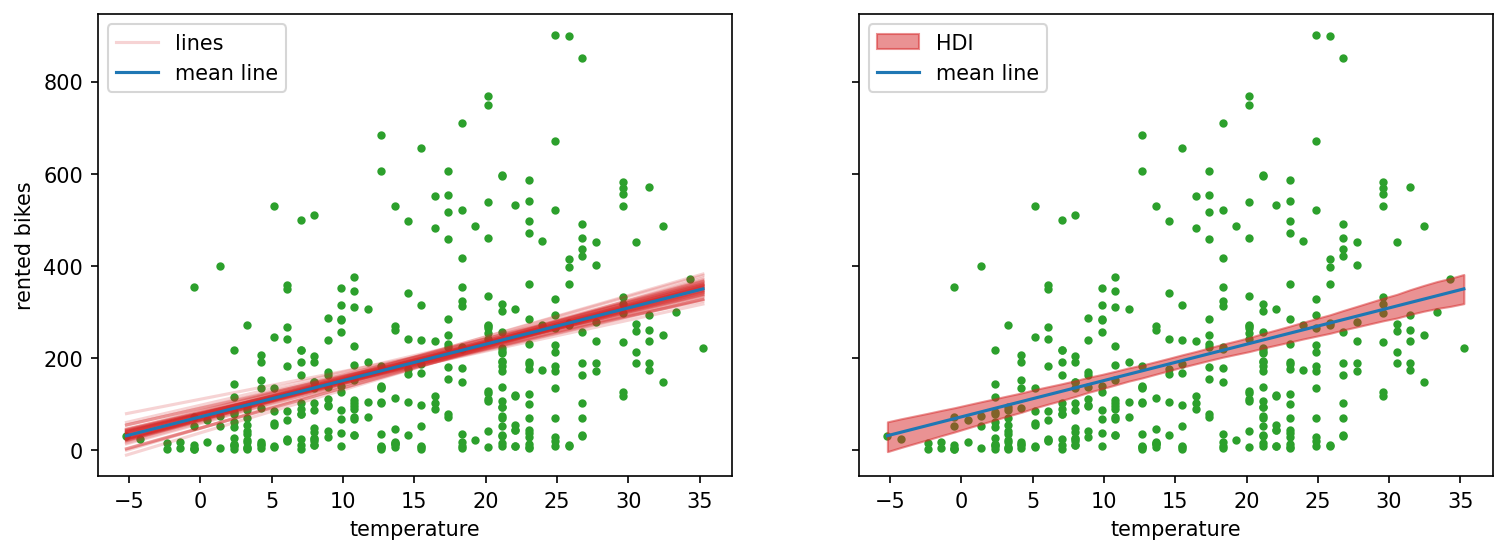

In [17]:
posterior = az.extract(idata_lb, num_samples=50)
x_plot = xr.DataArray(
    np.linspace(bikes.temperature.min(), bikes.temperature.max(), 50), dims="plot_id"
)
mean_line = posterior["β0"].mean() + posterior["β1"].mean() * x_plot
lines = posterior["β0"] + posterior["β1"] * x_plot
hdi_lines = az.hdi(idata_lb.posterior["μ"])


fig, axes = plt.subplots(1, 2, figsize=(12, 4), sharey=True)
axes[0].plot(bikes.temperature, bikes.rented, "C2.", zorder=-3)
lines_ = axes[0].plot(x_plot, lines.T, c="C3", alpha=0.2, label="lines")
plt.setp(lines_[1:], label="_")
axes[0].plot(x_plot, mean_line, c="C0", label="mean line")
axes[0].set_xlabel("temperature")
axes[0].set_ylabel("rented bikes")
axes[0].legend()

axes[1].plot(bikes.temperature, bikes.rented, "C2.", zorder=-3)
idx = np.argsort(bikes.temperature.values)
axes[1].fill_between(
    bikes.temperature[idx],
    hdi_lines["μ"][:, 0][idx],
    hdi_lines["μ"][:, 1][idx],
    color="C3",
    label="HDI",
    alpha=0.5,
)
axes[1].plot(x_plot, mean_line, c="C0", label="mean line")
axes[1].set_xlabel("temperature")
axes[1].legend()

In [15]:
pm.sample_posterior_predictive(idata_lb, model=model_lb, extend_inferencedata=True, random_seed=123)

Sampling: [y_pred]


Output()

Inference data with groups:
	> posterior
	> posterior_predictive
	> sample_stats
	> observed_data

In [25]:
y_hat_bounds = iter(
    [
        PchipInterpolator(temperatures[idx], y_pred_q[i][idx])(x)
        for i in range(4)
    ]
)
num_elements = list(y_hat_bounds)
num_elements

[array([-2.32343575e+02, -2.06363412e+02, -1.89408866e+02, -1.68333156e+02,
        -1.28750798e+02, -1.10951832e+02, -9.94554857e+01, -7.74172926e+01,
        -5.14701768e+01, -2.21544941e+01, -2.30204348e-01,  1.90778930e+01,
         4.39628194e+01,  6.34117615e+01,  8.63413407e+01]),
 array([289.21323118, 314.0667337 , 335.85080286, 351.40473753,
        383.92587149, 393.07993042, 421.28116739, 445.0899258 ,
        461.47666346, 493.52149037, 517.48292007, 536.45308973,
        566.21716467, 577.94674131, 600.96571822]),
 array([-66.04631429, -42.12779626, -17.57260438,  -0.94060039,
         30.93002443,  49.0547677 ,  70.67545338,  97.61295231,
        125.6329965 , 142.16799516, 166.61181115, 190.17997916,
        214.37559651, 236.25872264, 249.2543768 ]),
 array([120.76476301, 144.20115753, 169.87873115, 187.92412938,
        214.99819796, 239.13637726, 259.84385263, 286.95329489,
        300.51943845, 328.75682433, 354.64320487, 368.48666828,
        397.38506198, 424.87048

array([120.76476301, 146.19492525, 169.59535868, 190.09168892,
       210.6862515 , 235.57162642, 265.97712606, 279.48991396,
       302.86055568, 323.18581781, 344.8540732 , 369.85072754,
       397.20964172, 417.07371684, 433.81266967])

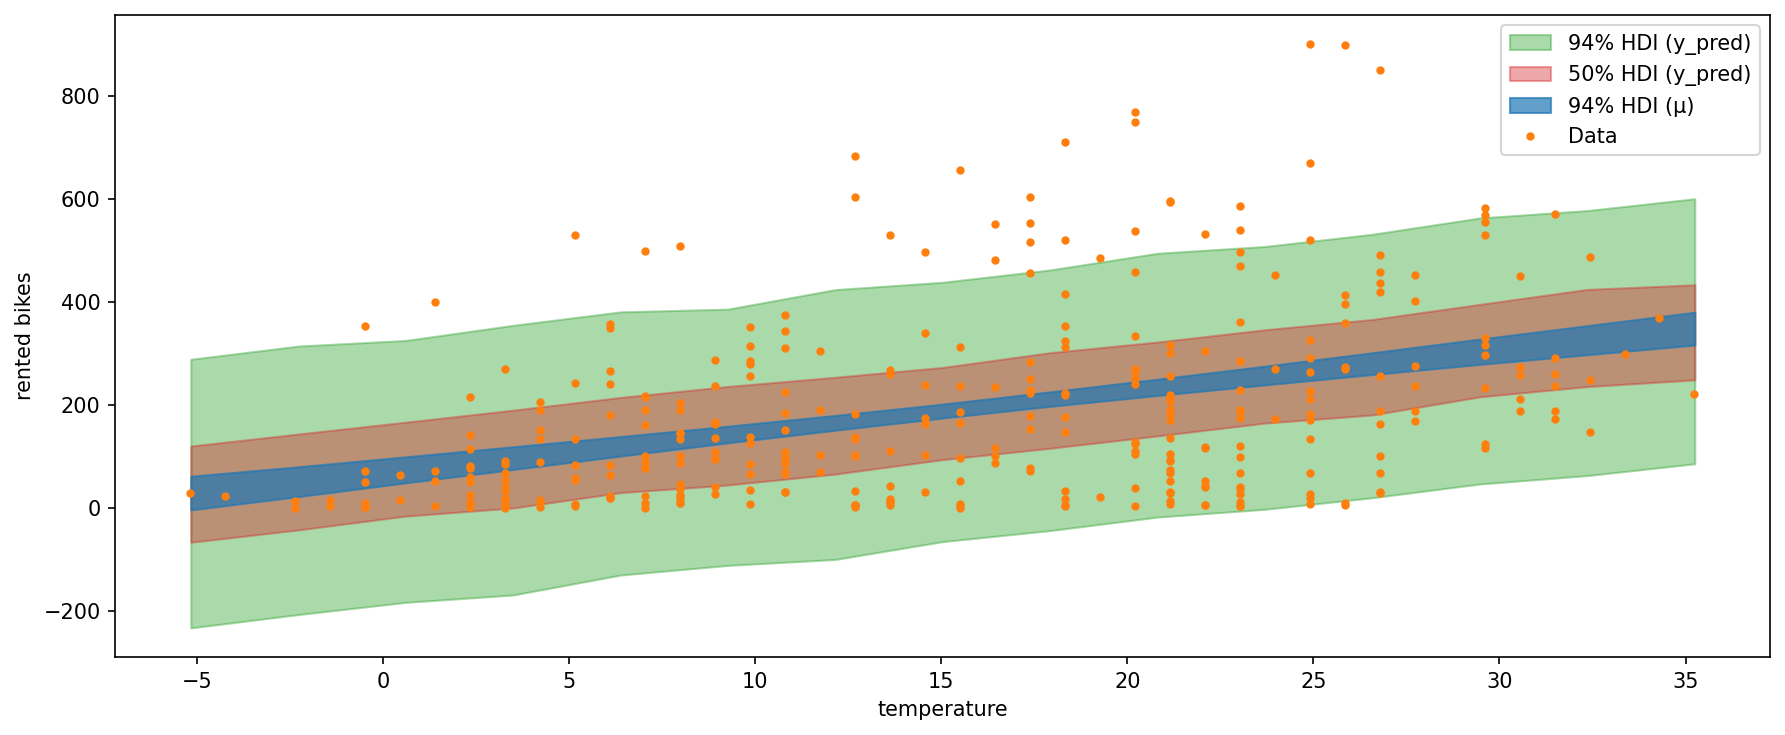

In [50]:
# Setup
temperatures = np.random.normal(bikes.temperature.values, 0.01)
idx = np.argsort(temperatures)
x = np.linspace(temperatures.min(), temperatures.max(), 15)

HDIs_pp = [0.94, 0.5]  # Multiple HDIs for posterior predictive
HDI_mu = 0.94          # Single HDI for posterior μ

# --- Posterior Predictive HDIs ---
pp_percentiles = []
for hdi in HDIs_pp:
    p_low = (1 - hdi) / 2
    p_high = 1 - p_low
    pp_percentiles.extend([p_low, p_high])

y_pred_q = idata_lb.posterior_predictive["y_pred"].quantile(pp_percentiles, dim=["chain", "draw"])

# Interpolated HDI bounds for y_pred
y_hat_bounds = {}
for i, hdi in enumerate(HDIs_pp):
    lb = y_pred_q[2 * i]
    ub = y_pred_q[2 * i + 1]
    y_hat_bounds[hdi] = (
        PchipInterpolator(temperatures[idx], lb[idx])(x),
        PchipInterpolator(temperatures[idx], ub[idx])(x)
    )

# --- Posterior μ HDI ---
p_low_mu = (1 - HDI_mu) / 2
p_high_mu = 1 - p_low_mu
mu_q = idata_lb.posterior["μ"].quantile([p_low_mu, p_high_mu], dim=["chain", "draw"])

mu_bounds = (
    PchipInterpolator(temperatures[idx], mu_q[0][idx])(x),
    PchipInterpolator(temperatures[idx], mu_q[1][idx])(x)
)

# --- Plot ---
_, ax = plt.subplots(figsize=(12, 5))
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

# Fill posterior predictive HDIs
for i, hdi in enumerate(HDIs_pp):
    lb, ub = y_hat_bounds[hdi]
    ax.fill_between(x, lb, ub, color=colors[i % len(colors)+2], alpha=0.4, label=f"{int(hdi*100)}% HDI (y_pred)", zorder=i)

# Fill μ HDI
mu_color = 'C0'
ax.fill_between(x, *mu_bounds, color=mu_color, alpha=0.7, label=f"{int(HDI_mu*100)}% HDI (μ)", zorder=len(HDIs_pp))

# Data points
ax.plot(bikes.temperature, bikes.rented, "C1.", label="Data", zorder=len(HDIs_pp)+1)

ax.set_xlabel("temperature")
ax.set_ylabel("rented bikes")
ax.legend()
plt.tight_layout()
plt.show()